In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import json
import numpy as np
import pandas as pd

from numpy.polynomial import Polynomial
from matplotlib.gridspec import GridSpec
from prototypefour import *

In [38]:
with open("data.json") as f:
    POSITION, LENGTH, BES1, CPD, ROT3, AUXIN = map(np.array, json.load(f).values())

## Brassinoslide Concentration Function

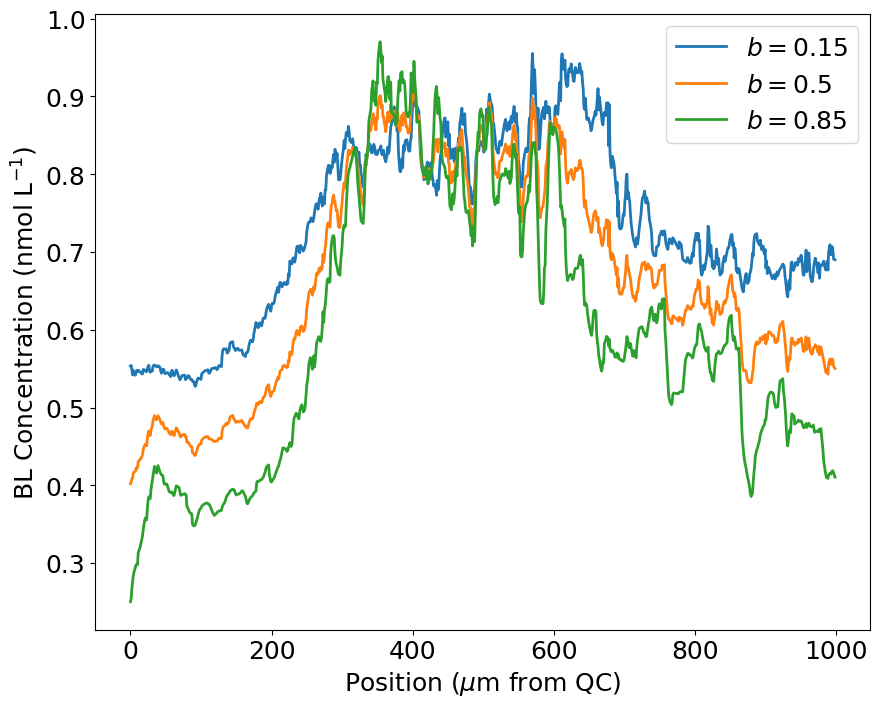

In [39]:
### FIGURE IN PAPER -- DO NOT CHANGE
xs = np.linspace(0, 999, 1000)
cpd_interp = np.interp(xs, CPD[:, 0], CPD[:, 1])
rot3_interp = np.interp(xs, ROT3[:, 0], ROT3[:, 1])
cpd_scaled = cpd_interp / max(cpd_interp)
rot3_scaled =  rot3_interp / max(rot3_interp)

for b in [0.15, 0.5, 0.85]:
    BL = b * cpd_scaled + (1 - b) * rot3_scaled
    plt.plot(xs, BL, lw = 2, label = fr"$b = {b}$")


mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 6)
plt.xlabel(r"Position ($\mu$m from QC)")
plt.ylabel(r"BL Concentration (nmol L$^{-1}$)")
plt.legend()
plt.savefig("img/prototype-5a-bl-function-bias", bbox_inches="tight")

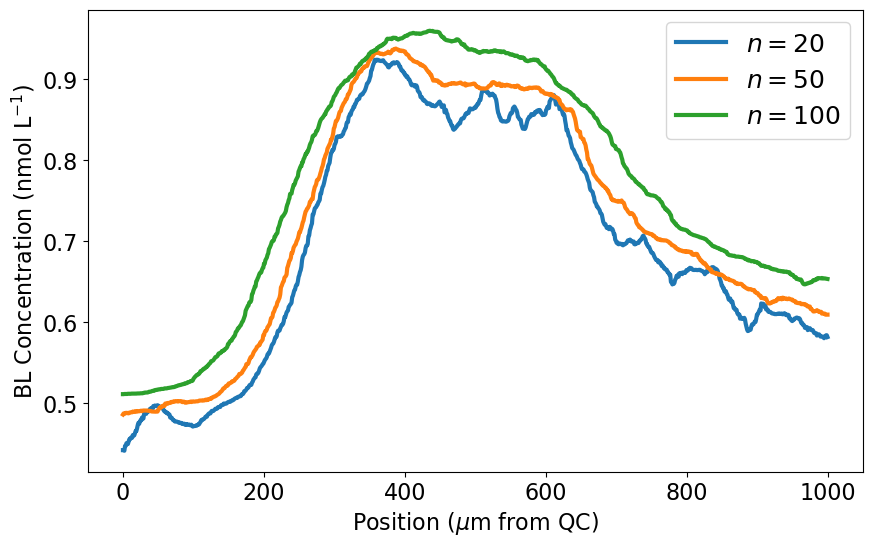

In [33]:
### FIGURE IN PAPER -- DO NOT CHANGE

xs = np.linspace(0, 999, 1000)
for n in [20, 50, 100]:
    cpd_averaged = moving_average(CPD, n)
    rot3_averaged = moving_average(ROT3, n)
    cpd_scaled = cpd_averaged / max(cpd_averaged)
    rot3_scaled =  rot3_averaged / max(rot3_averaged)
    BL = 0.5 * cpd_scaled + 0.5 * rot3_scaled
    plt.plot(xs, BL, lw = 3, label = fr"$n = {n}$")

mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 6)
plt.xlabel(r"Position ($\mu$m from QC)")
plt.ylabel(r"BL Concentration (nmol L$^{-1}$)")
plt.legend()
plt.savefig("img/prototype-5a-bl-function-average", bbox_inches="tight")

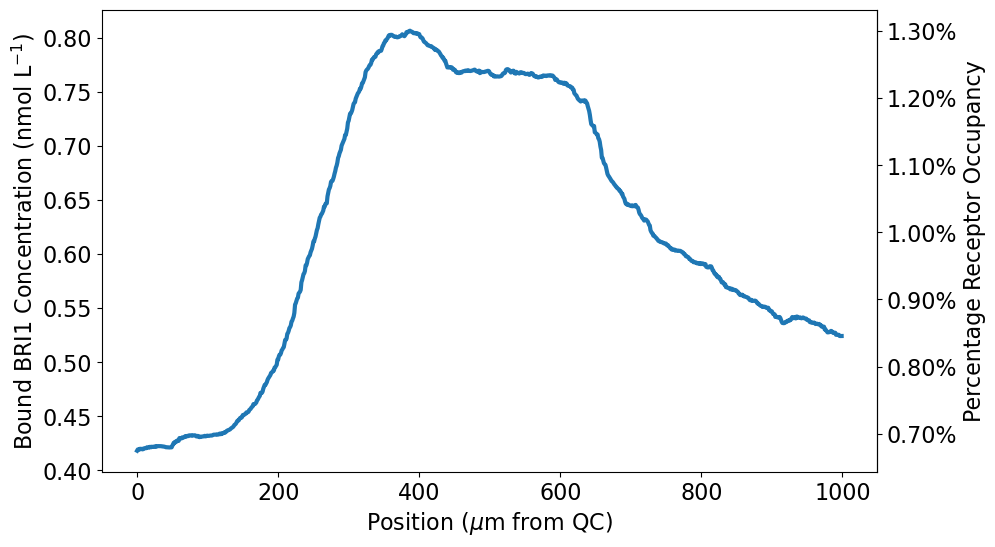

In [40]:
### FIGURE IN PAPER -- DO NOT CHANGE

# Get the BL function (n = 50, b = 0.5)
xs = np.linspace(0, 999, 1000)
cpd_averaged = moving_average(CPD, 50)
rot3_averaged = moving_average(ROT3, 50)
cpd_scaled = cpd_averaged / max(cpd_averaged)
rot3_scaled =  rot3_averaged / max(rot3_averaged)
BL = 0.5 * cpd_scaled + 0.5 * rot3_scaled

# Compute the bound receptors
A = (BL + 62 + 10)
RB = (A - np.sqrt(A ** 2 - 4 * 62 * BL)) / 2

# Plot the percentage of bound receptors and the absolute concentration
import matplotlib.ticker as mtick
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (10, 6)

fig, ax = plt.subplots()
ax.plot(xs, RB, lw = 3)
ax.set_xlabel(r"Position ($\mu$m from QC)")
ax.set_ylabel(r"Bound BRI1 Concentration (nmol L$^{-1}$)")

pct_to_abs = lambda x : x * 62
abs_to_pct = lambda x : 100 * x / 62
secax = ax.secondary_yaxis('right', functions = (abs_to_pct, pct_to_abs))
secax.set_ylabel(r"Percentage Receptor Occupancy")
secax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig("img/prototype-5a-rb-function", bbox_inches="tight")

## Position Function

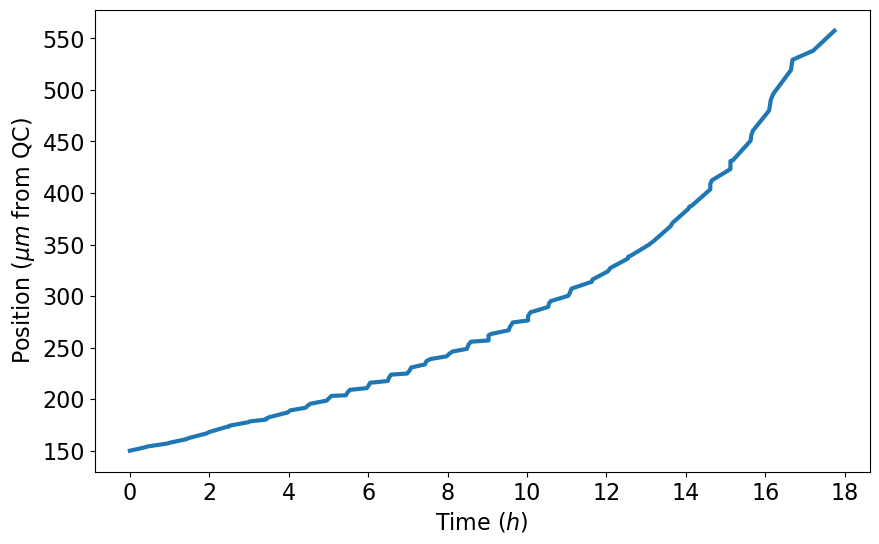

In [41]:
### FIGURE IN PAPER -- DO NOT CHANGE
plt.xlabel(r"Time ($h$)")
plt.ylabel(r"Position ($\mu m$ from QC)")
plt.xticks(np.arange(0, 20, 2))
plt.plot(POSITION[:, 0], POSITION[:, 1], lw = 3)
plt.savefig("img/prototype-5a-position-function", bbox_inches="tight")

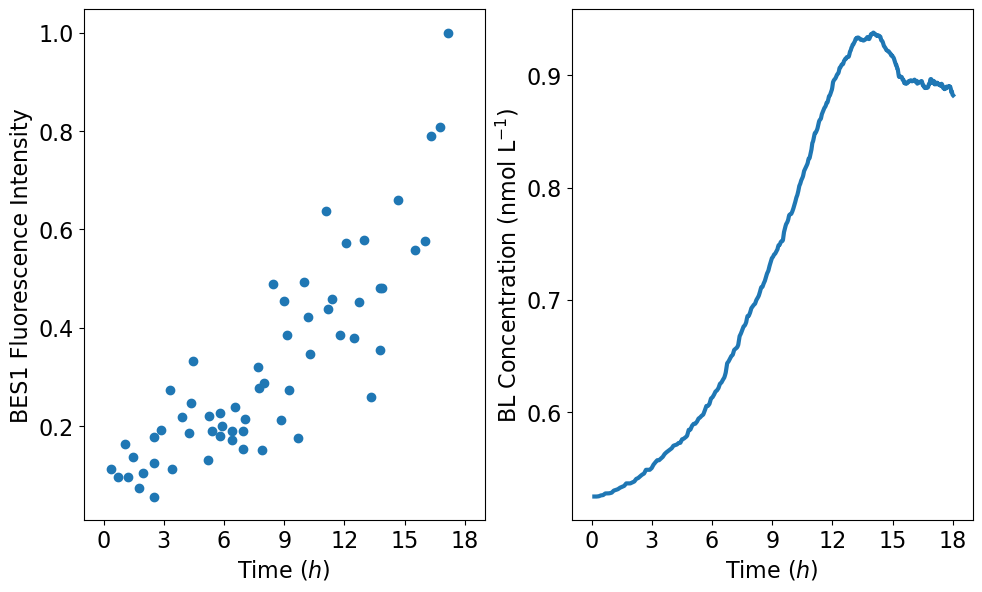

In [42]:
### FIGURE IN PAPER -- DO NOT CHANGE
time_to_position = np.poly1d(np.polyfit(POSITION[:, 0], POSITION[:, 1], 4))
position_to_time = np.poly1d(np.polyfit(POSITION[:, 1], POSITION[:, 0], 4))

# Get BL function in terms of position
cpd_averaged = moving_average(CPD, 50)
rot3_averaged = moving_average(ROT3, 50)
cpd_scaled = cpd_averaged / max(cpd_averaged)
rot3_scaled =  rot3_averaged / max(rot3_averaged)
BL = 0.5 * cpd_scaled + 0.5 * rot3_scaled

# Rescale BL function in terms of time
xs = np.linspace(0, 999, 1000)
xs_filtered = np.linspace(150, 600, 900)
xs_transformed = position_to_time(xs_filtered)
BL_interp = np.interp(xs_filtered, xs, BL)

# Rescale and transform BES1 data in terms of time
idx = np.where((BES1[:, 0] > 150) & (BES1[:, 0] < 600) & (BES1[:, 1] < 100))
BES1_filtered = BES1[idx]
BES1_times  = position_to_time(BES1_filtered[:, 0])
BES1_values = BES1_filtered[:, 1] / max(BES1_filtered[:, 1])

# Do a linear approximation of the BES1 data
ts = np.linspace(0, 18, 1000)
polyfit = Polynomial.fit(BES1_times, BES1_values, deg = 1)

# Plot the BES1 data and BL function
fig, (ax1, ax2) = plt.subplots(ncols = 2)
fig.tight_layout()

ax1.set_xlabel(r"Time ($h$)")
ax1.set_ylabel(r"BES1 Fluorescence Intensity")
ax1.set_xticks(np.arange(0, 21, 3))
ax1.set_yticks(np.arange(0, 1.2, 0.2))
ax1.set_xlim((-1, 19))
ax1.scatter(BES1_times, BES1_values)

ax2.set_xlabel(r"Time ($h$)")
ax2.set_ylabel(r"BL Concentration (nmol L$^{-1}$)")
ax2.set_xticks(np.arange(0, 21, 3))
ax2.set_xlim((-1, 19))
ax2.plot(xs_transformed, BL_interp, lw = 3, label = fr"$n = {n}$")
plt.savefig("img/prototype-5a-bes1-data", bbox_inches="tight")

## Mutant Data Processing

In [43]:
from prototypefive import parse_mutant_data
from scipy.optimize import curve_fit

def plot_data(cell_type : str):

    raw = (pd
        .read_csv(f"data/{cell_type}-areas.csv")
        .set_index("Cell Position")
    )


    for p, l, c in [("WT-", "Wild Type", "c"),
                    ("C1-", "CLASP-1", "r"),
                    ("BC-", "BRIN-CLASP", "k")]:
        
        data, N = parse_mutant_data(p, raw, 2)
        mask = np.where((data[:, 0] > 150) & (data[:, 0] < 550))

        td = position_to_time(data[mask, 0]).reshape(-1)
        yd = data[mask, 1].reshape(-1)

        f = lambda x, A, B, C : A + B * np.exp(C * x)
        popt, pcov = curve_fit(f, td, yd)
        ts = np.linspace(0, 18, 1000)
        
        plt.scatter(td, yd, s = 100, c = c, alpha = 0.3, marker = ".", edgecolors = "none")
        plt.plot(ts, f(ts, *popt), c = c, label = fr"{l} ($N = {N}$)")
    
    plt.xlabel(r"Time (h)")
    plt.ylabel(r"Cell Length ($\mu$m)")
    plt.xticks(np.arange(0, 20, 2))
    plt.title(f"Processed {cell_type.capitalize()} Data")
    plt.legend()
    
    mpl.rcParams['font.size'] = 18
    mpl.rcParams['figure.figsize'] = (10, 8)
    plt.savefig(f"img/prototype-5a-data-{cell_type}.png")

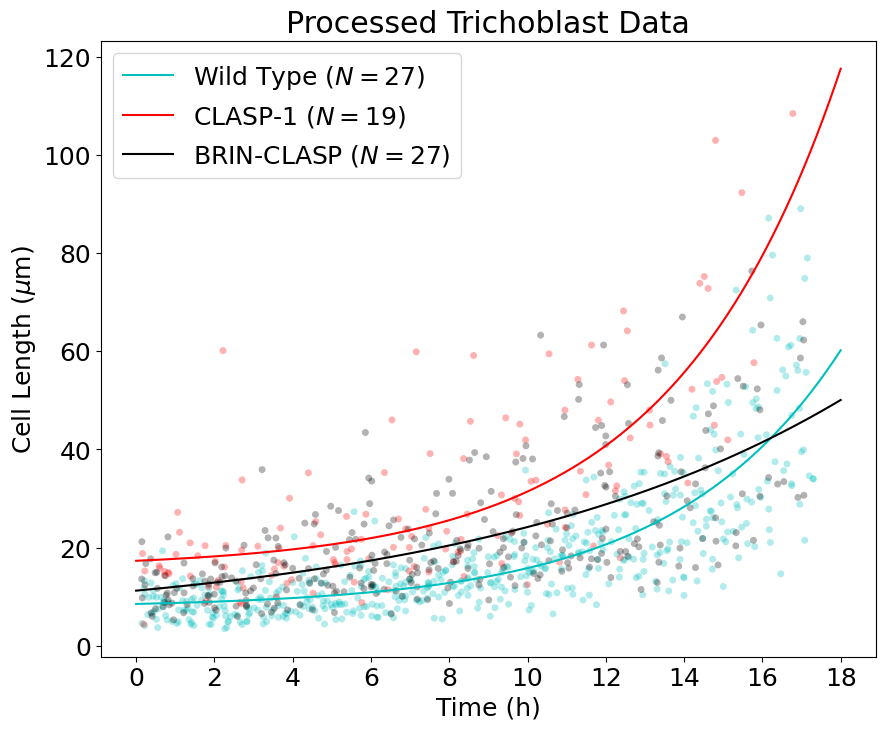

In [44]:
### FIGURE IN PAPER -- DO NOT CHANGE
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 8)
plot_data("trichoblast")

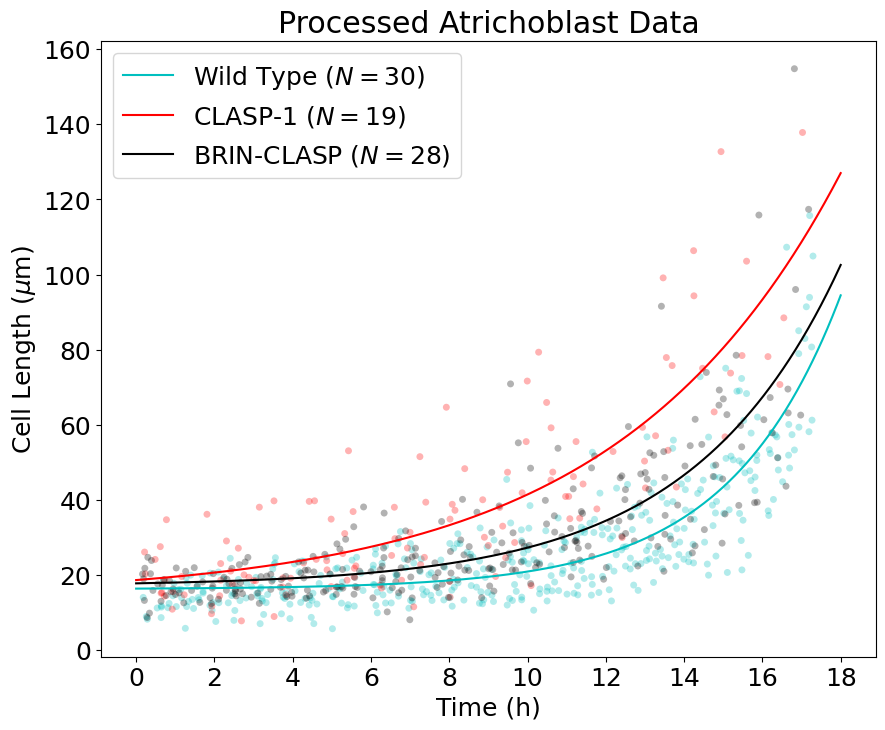

In [45]:
### FIGURE IN PAPER -- DO NOT CHANGE
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 8)
plot_data("atrichoblast")